The aim of this toy model is to illustrate the difference between estimating undirected connectivity with partial correlation (based on the zero-lag covariance matrix Q0) and directed connectivity based on time-shifted covariances of the observed activity (Q1 in addition to Q0). 

This provides the basic concepts to understand the paper on connectivity estimation based on the more elaborate gradient descent (Gilson et al., PLoS Comput Biol 2016).

The script generates activity for a network with linear feedback in continuous time (multivariate Ornstein-Uhlenbeck) and subsampled the activity. From the observed subsampled activity we calculating the covariance matrices Q0 and Q1. These observables are the basis for the Pearson correlations (K), partial correlation (P) and the multivariate autoregressive (MAR) estimates. Non-parametric significance testing is implemented using shuffling of the observed time series for the MAR estimate to identify the connections in the original connectivity C.

Goal:
- check influence of network parameters (size N, density p_C), simulation duration (T) and subsampling on connectivity estimates;
- evaluate sensitivity of statistical testing when varying the number of surrogates (n_shuf) and desired p-value (pval)

Refs:
- Gilson M, Moreno-Bote R, Ponce-Alvarez A, Ritter P, Deco G (2016) Estimation of directed Effective Connectivity from fMRI Functional Connectivity Hints at Asymmetries of Cortical Connectome. PLoS Comput Biol 12: e1004762; doi.org/10.1371/journal.pcbi.1004762
- en.wikipedia.org/wiki/Partial_correlation
- en.wikipedia.org/wiki/Autoregressive_model
- en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process


# Simulation

The multivariate Ornstein-Uhlenbeck process is simulated in discrete time, but with a small time step. The activity is subsampled with a sample every second here.

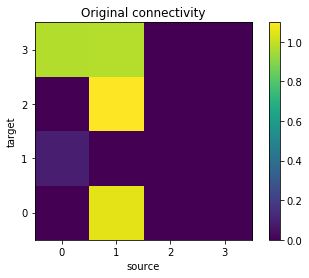

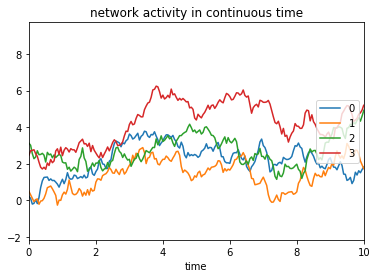

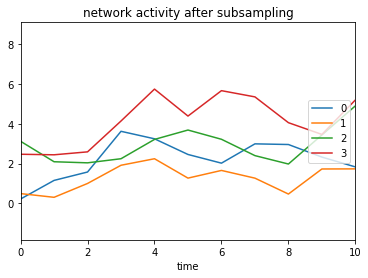

In [8]:
import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as pp

save_figs = False

# network and simulation parameters
N = 4 # number of nodes in network

tau_x = 1. # leakage time constant (common to all nodes)
p_C = 0.25 # theoretical density for connectivity
min_C = 0. # minimal weight (relative)

mask_diag = np.eye(N,dtype=np.bool) # mask for diagonal elements

T0 = 100. # initialization time for network dynamics
T = 1000. # simulation duration

dt = 0.05 # temporal resolution for simulation
n_sampl = int(1./dt) # sampling rate to get 1 point every second

# slower sampling rate
n_sampl2 = n_sampl * 10 # 1 point every 10 s
T2 = T * n_sampl / n_sampl2


# function to simulate network activity
def sim_net_act(T_sim,C_sim,I_sim,Sigma_sim,subsampling=True):
    nT = int(T_sim/dt) # simulation timesteps
    nT0 = int(T0/dt) # simulation timesteps to ignore (due to initial condition)
    # simulated Jacobian
    J_sim = -np.eye(N)/tau_x + C_sim
    # simulated input noise
    Sigma_mix = spl.sqrtm(Sigma_sim)
    # simulation of multivariate Ornstein-Uhlenbeck simulation
    ts_sim = np.zeros([nT,N]) # time series
    v_noise = np.random.normal(size=[nT0+nT,N],scale=(dt**0.5)) # input noise
    x = np.zeros([N]) # initial condition
    for iT in range(nT0+nT):
        x += dt*np.dot(J_sim,x) + I_sim + np.dot(Sigma_mix,v_noise[iT,:])
        if iT>=nT0:
            ts_sim[iT-nT0,:] = x
    # return simulated time series
    if subsampling:
        return ts_sim[::n_sampl,:]
    else:
        return ts_sim

    
# example simulation
if False:
    # randomly connected C
    good_C = False
    while not good_C:
        C = min_C + (1-min_C) * np.random.rand(N,N) # random connectivity
        C[np.random.rand(N,N)>p_C] = 0 # set theoretical density to p_C
        C[mask_diag] = 0 # eliminate self-connections
        C *= 0.8 / ((1+min_C)/2) / N / p_C # rescaling
        # check if feedback in C not too strong
        good_C = np.real(np.linalg.eigvals(C).max())<1
else:
    # special case
    C = np.array([[0,1.05287142,0,0],\
                  [0.0912281,0,0,0],\
                  [0,1.09834951,0,0],\
                  [0.97143995,0.97432828,0,0]])
I = 0.05 # constant input
Sigma = np.eye(N) # input covariance

ts_X = sim_net_act(T,C,I,Sigma,False)


# plots
T_aff = 10

pp.figure()
pp.title('Original connectivity')
pp.imshow(C,interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
pp.xlabel('source')
pp.ylabel('target')
pp.colorbar()
if save_figs:
    pp.savefig('orig_C')

pp.figure()
pp.title('network activity in continuous time')
pp.plot(np.arange(0,T,dt),ts_X)
pp.axis(xmin=0,xmax=T_aff)
pp.xlabel('time')
pp.legend(range(N),loc='right')
if save_figs:
    pp.savefig('ts_cont')

pp.figure()
pp.title('network activity after subsampling')
pp.plot(np.arange(0,T),ts_X[::n_sampl,:])
pp.axis(xmin=0,xmax=T_aff)
pp.xlabel('time')
pp.legend(range(N),loc='right')
if save_figs:
    pp.savefig('ts_ds1')

pp.show()


# Autocovariances

The autovariance quantifies the "memory depth" of the simulated time series, which is how a given sample influences the successive samples. Depending on the subsmpling (every second or every 10 seconds here), the successive observed samples are dependent or not. This is important to check to understand whether this "temporal information" can be used to retrieve the underlying connectivity.

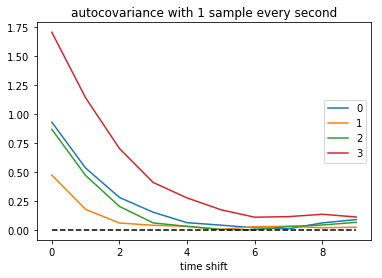

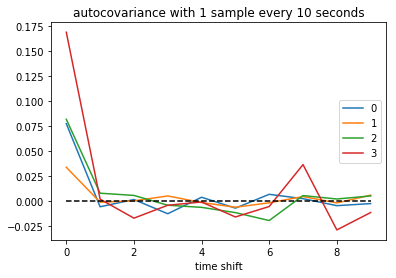

In [9]:
n_tau = 10 # number of time shifts

# demean subsampled time series
dm_ts_X = ts_X[::n_sampl,:]
dm_ts_X -= np.outer(np.ones([int(T)]),dm_ts_X.mean(0))

dm_ts_X2 = ts_X[::n_sampl2,:]
dm_ts_X2 -= np.outer(np.ones([int(T2)]),dm_ts_X.mean(0))

# autocovariance for discrete time series
ac = np.zeros([n_tau,N])
for i_tau in range(n_tau):
    ac[i_tau,:] = np.sum(dm_ts_X[0:int(T)-n_tau+1,:]*dm_ts_X[i_tau:int(T)-n_tau+1+i_tau,:],axis=0) / (T-n_tau)

# autocovariance for discrete time series
ac2 = np.zeros([n_tau,N])
for i_tau in range(n_tau):
    ac2[i_tau,:] = np.sum(dm_ts_X2[0:int(T2)-n_tau+1,:]*dm_ts_X2[i_tau:int(T2)-n_tau+1+i_tau,:],axis=0) / (T-n_tau)


# plots
pp.figure()
pp.title('autocovariance with 1 sample every second')
pp.plot(np.arange(0,n_tau),ac)
pp.plot([0,n_tau-1],[0,0],'--k')
pp.xlabel('time shift')
pp.legend(range(N),loc='right')
if save_figs:
    pp.savefig('ac_ds1')

pp.figure()
pp.title('autocovariance with 1 sample every 10 seconds')
pp.plot(np.arange(0,n_tau),ac2)
pp.plot([0,n_tau-1],[0,0],'--k')
pp.xlabel('time shift')
pp.legend(range(N),loc='right')
if save_figs:
    pp.savefig('ac_ds10')

pp.show()


# Covariances as observables

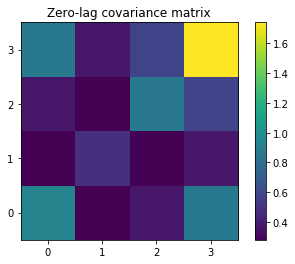

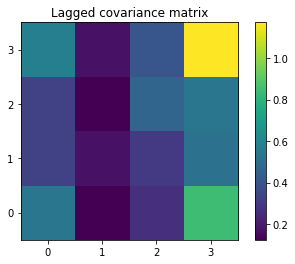

In [10]:
# observed time series
if True: # downsampling of 1 s
    ts_obs = dm_ts_X
    T_obs = int(T)
else: # downsampling of 10 s
    ts_obs = dm_ts_X2
    T_obs = int(T2)

# empirical covariances
Q0 = np.tensordot(ts_obs[0:T_obs-1,:],ts_obs[0:T_obs-1,:],axes=(0,0)) / (T_obs-2)
Q1 = np.tensordot(ts_obs[0:T_obs-1,:],ts_obs[1:T_obs,:],axes=(0,0)) / (T_obs-2)

# plots
pp.figure()
pp.title('Zero-lag covariance matrix')
pp.imshow(Q0,interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
pp.colorbar()
if save_figs:
    pp.savefig('Q0')

pp.figure()
pp.title('Lagged covariance matrix')
pp.imshow(Q1,interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
pp.colorbar()
if save_figs:
    pp.savefig('Q1')

pp.show()

# From observables to connectivity measures

From the observables, we calculate the connectivity estimates: Pearson correlation and partial correlation from Q0 only, while the MAR estimates uses both Q0 and Q1 (hence "temporal information").

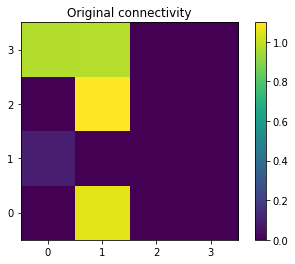

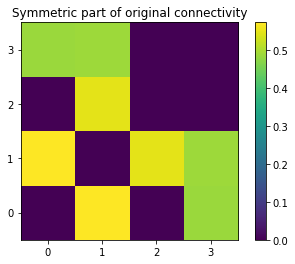

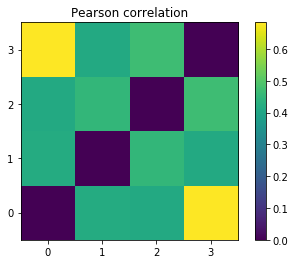

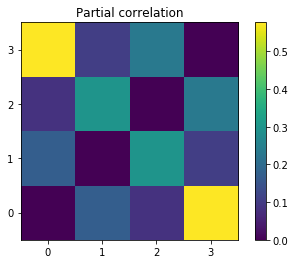

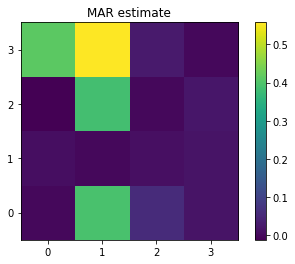

In [11]:
# Pearson correlations
K = np.array(Q0)
K /= np.sqrt(np.outer(K.diagonal(),K.diagonal()))
K[mask_diag] = 0

# partial correlation
P = -np.linalg.pinv(Q0)
P /= np.sqrt(np.outer(P.diagonal(),P.diagonal()))
P[mask_diag] = 0

# MAR estimate
A_MAR = np.dot(np.linalg.pinv(Q0),Q1).T
A_MAR[mask_diag] = 0


# plots
pp.figure()
pp.title('Original connectivity')
pp.imshow(C,interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
pp.colorbar()
if save_figs:
    pp.savefig('orig_C')

pp.figure()
pp.title('Symmetric part of original connectivity')
pp.imshow((C+C.T)*0.5,interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
pp.colorbar()
if save_figs:
    pp.savefig('sym_C')

pp.figure()
pp.title('Pearson correlation')
pp.imshow(K,interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
pp.colorbar()
if save_figs:
    pp.savefig('CORR')

pp.figure()
pp.title('Partial correlation')
pp.imshow(P,interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
pp.colorbar()
if save_figs:
    pp.savefig('PC')

pp.figure()
pp.title('MAR estimate')
pp.imshow(A_MAR,interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
pp.colorbar()
if save_figs:
    pp.savefig('A_MAR')

pp.show()

Note the different scales for the matrices above.

# Statistical testing

To check which estimated values are significantly different from 0, we compare these values with surrogates estimates by shuffling the time series.

True positive = hit: 4
False positive = false alarm: 0
False negative = miss: 1
True negative: 11


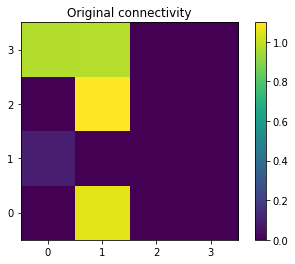

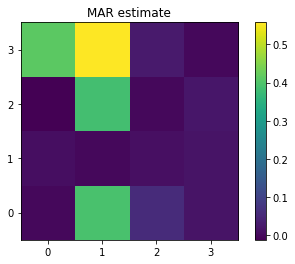

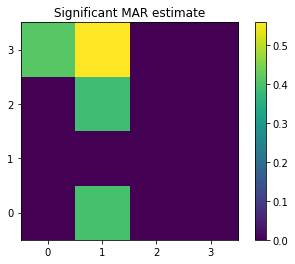

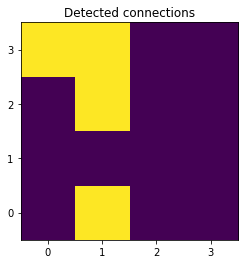

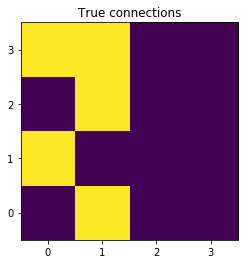

In [12]:
# shuffling by random permutation of samples within each time series
n_shuf = 100 # number of surrogates
pval = 0.05 # desired p-value

A_shuf = np.zeros([n_shuf,N,N])
for i_shuf in range(n_shuf):
    ts_shuf = np.array(ts_obs)
    for i in range(N):
        ts_shuf[:,i] = ts_shuf[np.argsort(np.random.rand(T_obs)),i]
    # empirical covariances
    Q0_shuf = np.tensordot(ts_shuf[0:T_obs-1,:],ts_shuf[0:T_obs-1,:],axes=(0,0)) / (T_obs-2)
    Q1_shuf = np.tensordot(ts_shuf[0:T_obs-1,:],ts_shuf[1:T_obs,:],axes=(0,0)) / (T_obs-2)
    # MAR estimate for shuffled time series
    A_shuf[i_shuf,:,:] = np.dot(np.linalg.pinv(Q0_shuf),Q1_shuf).T
    A_shuf[i_shuf,mask_diag] = 0

A_shuf = np.sort(A_shuf,axis=0)
    
# retain only MAR estimates that are stronger than 95%
A_sig = np.zeros(A_MAR.shape)
mask_sig = A_MAR>A_shuf[-int(n_shuf*pval),:,:]
A_sig[mask_sig] = A_MAR[mask_sig]
mask_C = C>0

print('True positive = hit:', np.logical_and(mask_sig,mask_C).sum())
print('False positive = false alarm:', np.logical_and(mask_sig,np.logical_not(mask_C)).sum())
print('False negative = miss:', np.logical_and(np.logical_not(mask_sig),mask_C).sum())
print('True negative:', np.logical_and(np.logical_not(mask_sig),np.logical_not(mask_C)).sum())

# plots
pp.figure()
pp.title('Original connectivity')
pp.imshow(C,interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
pp.colorbar()

pp.figure()
pp.title('MAR estimate')
pp.imshow(A_MAR,interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
pp.colorbar()

pp.figure()
pp.title('Significant MAR estimate')
pp.imshow(A_sig,interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
pp.colorbar()
if save_figs:
    pp.savefig('sig_MAR')

pp.figure()
pp.title('Detected connections')
pp.imshow(mask_sig.astype(np.int),interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
if save_figs:
    pp.savefig('detect_MAR')

pp.figure()
pp.title('True connections')
pp.imshow((C>0).astype(np.int),interpolation='nearest',origin='bottom')
pp.xticks(range(N))
pp.yticks(range(N))
if save_figs:
    pp.savefig('orig_conn')

pp.show()

Original connectivity
[[0.         1.05287142 0.         0.        ]
 [0.0912281  0.         0.         0.        ]
 [0.         1.09834951 0.         0.        ]
 [0.97143995 0.97432828 0.         0.        ]]


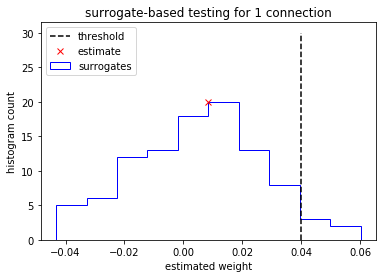

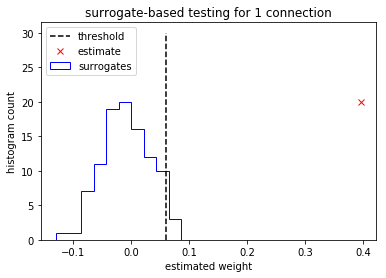

In [14]:
print('Original connectivity')
print(C)

i0 = 1 # target node for connection
j0 = 0 # source node for connection

pp.figure()
pp.title('surrogate-based testing for 1 connection')
pp.plot([A_shuf[-int(n_shuf*pval),i0,j0]]*2,[0,n_shuf*0.3],'--k')
pp.plot(A_MAR[i0,j0],n_shuf*0.2,'xr')
pp.hist(A_shuf[:,i0,j0],histtype='step',color='b')
pp.xlabel('estimated weight')
pp.ylabel('histogram count')
pp.legend(['threshold','estimate','surrogates'],loc='upper left')
if save_figs:
    pp.savefig('wrong_detect')

i0 = 0 # target node for connection
j0 = 1 # source node for connection

pp.figure()
pp.title('surrogate-based testing for 1 connection')
pp.plot([A_shuf[-int(n_shuf*pval),i0,j0]]*2,[0,n_shuf*0.3],'--k')
pp.plot(A_MAR[i0,j0],n_shuf*0.2,'xr')
pp.hist(A_shuf[:,i0,j0],histtype='step',color='b')
pp.xlabel('estimated weight')
pp.ylabel('histogram count')
pp.legend(['threshold','estimate','surrogates'],loc='upper left')
if save_figs:
    pp.savefig('correct_detect')

pp.show()